(air-convert-tf-to-air)=

# Convert existing Tensorflow/Keras code to Ray AIR

If you already have working Tensorflow code, you don’t have to start from scratch to utilize the benefits of Ray AIR. Instead, you can continue to use your existing code and incrementally add Ray AIR components as needed.

Some of the benefits you’ll get by using Ray AIR with your existing Tensorflow training code:

- Easy distributed data-parallel training on a cluster
- Automatic checkpointing/fault tolerance and result tracking
- Parallel data preprocessing
- Seamless integration with hyperparameter tuning
- Scalable model serving

This tutorial will show you how to start with Ray AIR from your existing Tensorflow training code. We will learn how to perform **distributed data-parallel training**.

## Example Code

The example code we’ll be converting to Ray AIR is that of the [Tensorflow quickstart tutorial](https://www.tensorflow.org/tutorials/quickstart/beginner). This code trains a neural network classifier on the MNIST dataset.

Follow along with this example by launching the notebook using the 🚀 icon above!

## Existing Tensorflow Code

Let’s start with the unmodified code from the example. A thorough explanation of the parts is given in the full tutorial - we’ll just focus on the code here.

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.9.2


First, we load and preprocess the MNIST dataset.

Assumption for this tutorial: your existing code is using the `tf.data.Dataset` native to Tensorflow. This tutorial continues to use `tf.data.Dataset` to allow you to make as few code changes as possible. **Everything in this tutorial is also possible if you choose to use Ray Data, and you will also get the benefits of efficient preprocessing and multi-worker batch prediction.** See [here](train-datasets) for resources to get started with Ray Data.

In [28]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(len(x_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

print(f"Training Dataset: {len(x_train)} samples")
print(f"Test Dataset: {len(x_test)} samples")

Training Dataset: 60000 samples
Test Dataset: 10000 samples


Next, we define the model architecture of the neural network. We wrap the model definition inside a function for easy reuse later.

In [3]:
def build_model() -> tf.keras.Model:
    return tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(10),
        ]
    )

Next, initialize the model, loss, optimizer, and define some metrics that we want to track during training.

We recommend using the Keras `Model.fit` API, as it simplifies distributing your training with `tf.distribute` and Ray AIR. Compile your model with a loss function and optimizer, then run `model.fit(train_ds)`.

In [4]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

model = build_model()
model.compile(
    optimizer=optimizer,
    loss=loss_object,
    metrics=["accuracy"],
)

Next, we train the model for some number of epochs, updating the model parameters to minimize the loss. Each epochs loop through the entire training dataset and perform gradient descent steps.

In [5]:
train_history = model.fit(train_ds, epochs=5, verbose=2)

Epoch 1/5
1875/1875 - 3s - loss: 0.2954 - accuracy: 0.9134 - 3s/epoch - 2ms/step
Epoch 2/5
1875/1875 - 3s - loss: 0.1437 - accuracy: 0.9567 - 3s/epoch - 2ms/step
Epoch 3/5
1875/1875 - 3s - loss: 0.1078 - accuracy: 0.9673 - 3s/epoch - 1ms/step
Epoch 4/5
1875/1875 - 3s - loss: 0.0860 - accuracy: 0.9736 - 3s/epoch - 1ms/step
Epoch 5/5
1875/1875 - 3s - loss: 0.0746 - accuracy: 0.9760 - 3s/epoch - 2ms/step


After training, we evaluate the model's performance on the test set.

In [6]:
# Evaluate on the test set and report metrics
eval_result = model.evaluate(test_ds, return_dict=True, verbose=0)
test_loss = eval_result["loss"]
test_accuracy = eval_result["accuracy"]
print(
    f"Final Test Loss: {test_loss:.4f}, "
    f"Final Test Accuracy: {test_accuracy:.4f}"
)

313/313 - 0s - loss: 0.0735 - accuracy: 0.9788 - 457ms/epoch - 1ms/step
Final Test Loss: 0.0735, Final Test Accuracy: 0.9788


## Wrap everything in a training loop function

Later on, we might want to perform hyperparameter optimization and launch multiple training runs, so it is useful to wrap the training logic we have so far in a function. We also introduce a function to get the training and test datasets, which is used within the training function.

In [7]:
def get_train_test_datasets(batch_size):
    train_ds = tf.data.Dataset.from_tensor_slices(
        (x_train, y_train)).shuffle(len(x_train)).batch(batch_size)
    test_ds = tf.data.Dataset.from_tensor_slices(
        (x_test, y_test)).batch(batch_size)

    return train_ds, test_ds

def train_func():
    epochs = 5
    batch_size = 32

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam()

    model = build_model()
    model.compile(
        optimizer=optimizer,
        loss=loss_object,
        metrics=["accuracy"],
    )
    
    train_ds, test_ds = get_train_test_datasets(batch_size)
    
    model.fit(train_ds, epochs=epochs, verbose=2)
    
    eval_result = model.evaluate(test_ds, return_dict=True, verbose=0)
    test_loss = eval_result["loss"]
    test_accuracy = eval_result["accuracy"]
    print(
        f"Final Test Loss: {test_loss:.4f}, "
        f"Final Test Accuracy: {test_accuracy:.4f}"
    )

## Introduce Ray AIR for Distributed Data-Parallel Training

Now that we have set up a training loop that runs on a single worker, let's use Ray AIR to implement **distributed training**, allowing us to train using any number of workers!

Ray Train, the model training library within Ray AIR, implements a `TensorflowTrainer` that allows you to do [distributed training with Tensorflow](https://www.tensorflow.org/guide/distributed_training) without needing to create and handle workers manually. Ray Train creates workers in a Ray cluster and configures the `TF_CONFIG` environment variable for you. This way, you can use simply use a strategy from `tf.distribute` to run your training loop across multiple workers in a distributed data-parallel fashion! Currently, the only multi-worker strategy that Train supports is [`tf.distribute.MultiWorkerMirroredStrategy`](https://www.tensorflow.org/guide/distributed_training#multiworkermirroredstrategy), which shards the dataset evenly across workers and synchronizes parameter updates so that workers share the same weights at all times.

Let's start by installing Ray and AIR modules if we haven't already:

In [ ]:
!pip install "ray[air]"

### Update the train function

As a first step, let's implement the following:

1. Add a `config` argument as an easy way to pass in hyperparameters such as `batch_size_per_worker` through Ray Train.
2. Set up the model to **communicate gradients and synchronize model weights** between workers under the `tf.distribute.MultiWorkerMirroredStrategy` strategy.
3. Enable data-parallel distributed training by **sharding the training data** (and test data) so that each worker only deals with a subset of the data.
4. **Enable checkpointing and metric reporting** to get access to the trained model and results after our training job has finished.

We only need change a few lines of code:

```python
from ray.air import session
from ray.air.integrations.keras import ReportCheckpointCallback

# 1. Add a `config` argument to the train function to pass in hyperparameters

def train_func(config: dict):
    epochs = config.get("epochs", 5)
    batch_size_per_worker = config.get("batch_size", 32)
    
    # 2. Build and compile the model within tf.distribute strategy scope
    
    # Important: The strategy must be instantiated at the beginning
    # of the function, since the tf.Dataset that we load later needs
    # to be auto-sharded.
    # See https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras
    # for more details.
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    with strategy.scope(): 
        loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        optimizer = tf.keras.optimizers.Adam()

        model = build_model()
        model.compile(
            optimizer=optimizer,
            loss=loss_object,
            metrics=["accuracy"],
        )
    
    # 3. Set a `global_batch_size` so that every worker gets the specified
    #    `batch_size_per_worker` regardless of the number of workers.
    #    This is needed because the datasets are sharded across workers.

    global_batch_size = batch_size_per_worker * session.get_world_size()
    train_ds, test_ds = get_train_test_datasets(global_batch_size)
    # ^ Even though we are loading the datasets the same way as before, the
    # TF dataset will automatically shard the datasets across workers,
    # according to the strategy.
    
    # ...
    
    # 4. Use a Keras callback provided by Ray AIR to report metrics and checkpoint
    report_metrics_and_checkpoint_callback = ReportCheckpointCallback(report_metrics_on="epoch_end")

    model.fit(
        ...,
        callbacks=[report_metrics_and_checkpoint_callback]
    )
```

We see above that we pass a Keras {class}`ReportCheckpointCallback <ray.air.integrations.keras.ReportCheckpointCallback>` into `Model.fit`, which is an AIR integration that reports metrics and saves checkpoints after each epoch (configurable via the `on` parameter). The callback will automatically report metrics such as `loss` and `accuracy` that are specified when compiling the model.

Let's see the updated training function after these additions:

In [9]:
from ray.air import session
from ray.air.integrations.keras import ReportCheckpointCallback

# 1. Pass in the hyperparameter config
def train_func(config: dict):
    epochs = config.get("epochs", 5)
    batch_size_per_worker = config.get("batch_size", 32)
    
    # 2. Synchronized model setup
    strategy = tf.distribute.MultiWorkerMirroredStrategy()
    with strategy.scope(): 
        loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        optimizer = tf.keras.optimizers.Adam()
        
        model = build_model()
        model.compile(
            optimizer=optimizer,
            loss=loss_object,
            metrics=["accuracy"],
        )

    # 3. Shard the dataset across `session.get_world_size()` workers
    global_batch_size = batch_size_per_worker * session.get_world_size()
    train_ds, test_ds = get_train_test_datasets(batch_size_per_worker)

    if session.get_world_rank() == 0:
        print(f"\nDataset is sharded across {session.get_world_size()} workers:")
        # The number of samples is approximate, because is not always
        # a multiple of batch_size, so some batches could contain fewer than
        # `batch_size_per_worker` samples.
        print(
            f"# training batches per worker = {len(train_ds)} "
            f"(~{len(train_ds) * batch_size_per_worker} samples)"
        )
        print(
            f"# test batches per worker = {len(test_ds)} "
            f"(~{len(test_ds) * batch_size_per_worker} samples)"
        )
  
    # 4. Report metrics and checkpoint the model
    report_metrics_and_checkpoint_callback = ReportCheckpointCallback(report_metrics_on="epoch_end")
    model.fit(
        train_ds,
        epochs=epochs,
        callbacks=[report_metrics_and_checkpoint_callback],
        verbose=(0 if session.get_world_rank() != 0 else 2),
    )

    eval_result = model.evaluate(test_ds, return_dict=True, verbose=0)
    test_loss = eval_result["loss"]
    test_accuracy = eval_result["accuracy"]
    if session.get_world_rank() == 0:
        print(
            f"Final Test Loss: {test_loss:.4f}, "
            f"Final Test Accuracy: {test_accuracy:.4f}"
        )

A few notes on the [`session` API](air-session-ref) introduced by Ray AIR:
- {meth}`session.get_world_size() <ray.air.session.get_world_size>` is a Ray AIR helper that gets the number of workers doing training.
- In the updated code below, we also use the helper {meth}`session.get_world_rank() <ray.air.session.get_world_rank>` to only print logs on the head worker node (with rank 0) so that the output isn't spammed by logs from all workers.

### Move data loading inside of the training function

One important detail is that we should not try to use loaded data from outside of the training function. If we try to reference the training data from outside the training function, Ray serializes it to make it accessible to the remote tasks (that may get executed on a remote node!), and it's not ideal to ship the data around the cluster unnecessarily. Instead, move the dataset loading part into the `train_func()`. This will download the data *to disk once per machine* and result in much more efficient data loading.

Let's update the `get_train_test_datasets` method to load the MNIST dataset rather than use a reference from outside the train function.

In [10]:
def get_train_test_datasets(batch_size):
    # NEW: Now, the dataset will be downloaded to disk once per machine
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train / 255.0, x_test / 255.0
    
    train_ds = tf.data.Dataset.from_tensor_slices(
        (x_train, y_train)).shuffle(len(x_train)).batch(batch_size)
    test_ds = tf.data.Dataset.from_tensor_slices(
        (x_test, y_test)).batch(batch_size)
    return train_ds, test_ds

### Start training with `TensorflowTrainer`

Now, we’ll use Ray Train’s `TensorflowTrainer` to kick off the distributed training.

A few notes on the configs set below:
- `train_loop_config` sets the hyperparameters passed into the training loop as the `config` parameter
- `scaling_config` configures **how many parallel workers to use**, the **resources required per worker**, and whether we want to **enable GPU training** or not.

See this [configuration guide](train-config) for more details on how to configure the trainer.

In [ ]:
from ray import air
from ray.train.tensorflow import TensorflowTrainer

num_workers = 2
use_gpu = False

trainer = TensorflowTrainer(
    train_loop_per_worker=train_func,
    train_loop_config={
        "batch_size": 32,
        "epochs": 4,
    },
    scaling_config=air.ScalingConfig(
        num_workers=num_workers,
        use_gpu=use_gpu,
    ),
)
result = trainer.fit()

Great, this works 🎉! You’re now training your model in parallel. You could now scale this up to more nodes and workers on your Ray cluster.

We can use the training `Result` output of `trainer.fit()` to view some reported metrics. See the {class}`Result <ray.air.result.Result>` documentation for a full list of what's available. Let's plot the training loss vs. training iteration.

<AxesSubplot: xlabel='training_iteration'>

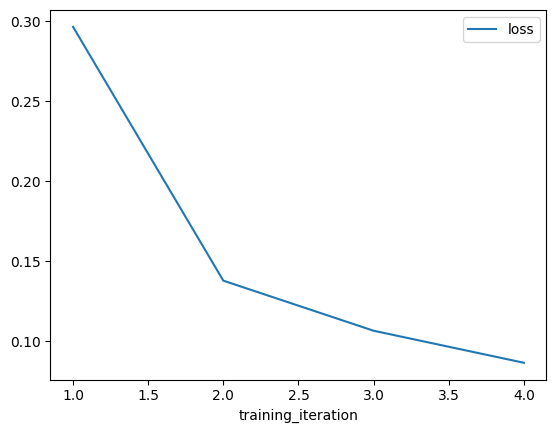

In [19]:
result.metrics_dataframe.plot("training_iteration", "loss")

## Summary

This tutorial demonstrated how a few lines of code with Ray AIR API's can allow you to scale up your Tensorflow model training.

We learned how to:
- enable distributed training using Ray Train abstractions
- save and retrieve model checkpoints via Ray AIR
- load a model for batch prediction

In our [other examples](air-examples-ref) you can learn how to do more things with the Ray AIR API, such as **serving your model with Ray Serve** or **tune your hyperparameters with Ray Tune**. You can also learn how to perform {ref}`offline batch inference <batch_inference_home>` with Ray Data.

See [this table](train-framework-catalog) for a full catalog of frameworks that AIR supports out of the box.

We hope this tutorial gave you a good starting point to leverage Ray AIR. If you have any questions, suggestions, or run into any problems pelase reach out on [Discuss](https://discuss.ray.io/), [GitHub](https://github.com/ray-project/ray) or the [Ray Slack](https://forms.gle/9TSdDYUgxYs8SA9e8)!